In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!apt-get update && apt-get install -y ffmpeg  # Fix for TorchCodec/FFmpeg issues
!pip install -q datasets==2.21.0 accelerate peft bitsandbytes jiwer evaluate librosa soundfile transformers

Get:1 https://cli.github.com/packages stable InRelease [3,917 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [2,149 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 https://r2u.stat.illinois.edu/ubuntu jammy/main all Pack

In [ ]:
from datasets import load_dataset, concatenate_datasets, Audio

# Load the dataset (it has multiple 'train.*' splits)
nepali = load_dataset("amitpant7/nepali-speech-to-text")

# Concatenate all train splits (ignore any test if present)
train_splits = [split for split in nepali if 'train' in split]
nepali_train = concatenate_datasets([nepali[split] for split in train_splits])

# Cast the audio column to Audio feature type for compatibility
nepali_train = nepali_train.cast_column("audio", Audio(sampling_rate=16_000))

print(f"Loaded {len(nepali_train)} training samples.")
print(nepali_train)
print(nepali_train[0])  # Preview one example

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Repo card metadata block was not found. Setting CardData to empty.


Generating train.0 split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating train.1 split:   0%|          | 0/1000 [00:00<?, ? examples/s]

Generating train.2 split:   0%|          | 0/650 [00:00<?, ? examples/s]

Loaded 2650 training samples.
Dataset({
    features: ['audio', 'transcription'],
    num_rows: 2650
})
{'audio': {'path': 'train_audio_0.wav', 'array': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        9.42416955e-06,  5.37711458e-06, -5.44977956e-06]), 'sampling_rate': 16000}, 'transcription': 'म पनि जान्छु है त अहिले लाई ।'}


In [ ]:
from datasets import load_from_disk, Audio
custom_path = "/content/drive/MyDrive/nepali_asr_dataset"
custom = load_from_disk(custom_path)

# -------------------------------------------------
if "sentence" in custom.column_names:
    custom = custom.rename_column("sentence", "transcription")

# Cast the audio column to Audio feature type for compatibility
custom = custom.cast_column("audio", Audio(sampling_rate=16_000))

# Ensure both have the same two columns
assert set(nepali_train.column_names) == {"audio", "transcription"}
assert set(custom.column_names) == {"audio", "transcription"}

print("\nCustom samples :")
print(custom)
print("\nCustom example:")
print(custom[0])


Custom samples :
Dataset({
    features: ['audio', 'transcription'],
    num_rows: 333
})

Custom example:
{'audio': {'path': None, 'array': array([-9.15527344e-05, -1.37329102e-03, -2.25830078e-03, ...,
       -4.48608398e-03, -3.99780273e-03, -2.25830078e-03]), 'sampling_rate': 16000}, 'transcription': 'महेश कुमार महरा । समय ६ मिनेट । यसपछि माननीय दिल कुमारी रावल ।'}


In [ ]:
import re
import unicodedata
def norm(example):
    t = example["transcription"]
    t = unicodedata.normalize("NFC", t.strip())
    t = re.sub(r"\s+", " ", t)          # collapse whitespace
    example["transcription"] = t
    return example

public = nepali_train.map(norm, num_proc=2)
custom = custom.map(norm, num_proc=2)

Map (num_proc=2):   0%|          | 0/2650 [00:00<?, ? examples/s]

In [ ]:
# --- CRITICAL: Cast BOTH to Audio() feature ---
public = public.cast_column("audio", Audio(sampling_rate=16000))
custom = custom.cast_column("audio", Audio(sampling_rate=16000))

In [ ]:
import numpy as np # Import numpy for potential future use or if needed by concatenate_datasets
from datasets import concatenate_datasets

# Oversample (10×) and concatenate
# -------------------------------------------------
OVERSAMPLE = 10

# Alternative to .repeat() that is robust to the AttributeError
custom_oversampled = concatenate_datasets([custom] * OVERSAMPLE)

combined = concatenate_datasets([public, custom_oversampled]).shuffle(seed=42)

print("\n=== FINAL COMBINED ===")
print(f"Public          : {len(public)}")
print(f"Custom (raw)    : {len(custom)}  →  {len(custom_oversampled)} after {OVERSAMPLE}× oversample")
print(f"Total training  : {len(combined)}")


=== FINAL COMBINED ===
Public          : 2650
Custom (raw)    : 333  →  3330 after 10× oversample
Total training  : 5980


In [ ]:
print(public.features["audio"])
# → Audio(sampling_rate=16000, ...)

print(custom.features["audio"])
# → {'array': Sequence(...), 'path': Value('string'), ...}

Audio(sampling_rate=16000, mono=True, decode=True, id=None)
Audio(sampling_rate=16000, mono=True, decode=True, id=None)


In [ ]:
from transformers import WhisperProcessor
import torch

# Load processor with Nepali
processor = WhisperProcessor.from_pretrained(
    "openai/whisper-small",
    task="transcribe"
)

# CORRECT: Whisper uses 448 tokens max
MAX_LABEL_LENGTH = 448

In [ ]:
def prepare(example):
    audio = example["audio"]

    # FIX: Use feature_extractor ONLY
    example["input_features"] = processor.feature_extractor(
        audio["array"],
        sampling_rate=audio["sampling_rate"],
        return_tensors="pt"
    ).input_features[0]  # Shape: (80, 3000)

    # Tokenize text (no truncation yet)
    example["labels"] = processor.tokenizer(
        example["transcription"]
    ).input_ids

    return_cloned = processor.tokenizer.pad({"input_ids": [example["labels"]]}, return_tensors="pt")
    example["labels"] = return_cloned["input_ids"][0].tolist()

    return example

# Map safely
processed_dataset = combined.map(
    prepare,
    remove_columns=combined.column_names,
    num_proc=1,
    batched=False
)

# Filter long labels
print(f"Filtering samples > {MAX_LABEL_LENGTH} tokens...")
initial_count = len(processed_dataset)
processed_dataset = processed_dataset.filter(
    lambda x: len(x["labels"]) <= MAX_LABEL_LENGTH
)
filtered_count = len(processed_dataset)
print(f"Removed {initial_count - filtered_count} samples. Remaining: {filtered_count}")

# Split
processed_dataset_splits = processed_dataset.train_test_split(test_size=0.1, shuffle=True, seed=42)
print("Final splits:", processed_dataset_splits)

# Save
processed_dataset_splits.save_to_disk("/content/drive/MyDrive/nepali_whisper_processed")

Map:   0%|          | 0/5980 [00:00<?, ? examples/s]

You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Filtering samples > 448 tokens...


Filter:   0%|          | 0/5980 [00:00<?, ? examples/s]

Removed 940 samples. Remaining: 5040
Final splits: DatasetDict({
    train: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 4536
    })
    test: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 504
    })
})


Saving the dataset (0/9 shards):   0%|          | 0/4536 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/504 [00:00<?, ? examples/s]

In [ ]:
from datasets import load_from_disk
import torch
from transformers import WhisperProcessor
from peft import LoraConfig, get_peft_model, TaskType

# Load saved dataset (includes train/test splits)
nepali_train = load_from_disk("/content/drive/MyDrive/nepali_whisper_processed")
print("Loaded dataset:", nepali_train)
print(f"Train samples: {len(nepali_train['train'])}, Eval samples: {len(nepali_train['test'])}")

# Reload processor (for collator and metrics)
processor = WhisperProcessor.from_pretrained(
    "openai/whisper-small",
    language="ne",
    task="transcribe"
)

# Your compute_metrics function (from previous cell)
import evaluate
wer_metric = evaluate.load("wer")

def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

Loaded dataset: DatasetDict({
    train: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 4536
    })
    test: Dataset({
        features: ['input_features', 'labels'],
        num_rows: 504
    })
})
Train samples: 4536, Eval samples: 504


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

normalizer.json: 0.00B [00:00, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

In [ ]:
import torch
from dataclasses import dataclass
from typing import Any, Dict, List, Union

from transformers import (
    WhisperProcessor,
    WhisperForConditionalGeneration,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer
)
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model

# -----------------------------
# CORRECTED Data collator for Whisper
# -----------------------------
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # input_features already processed, just stack them
        input_features = [torch.tensor(f["input_features"]) for f in features]

        # Pad input features to same length
        input_features = torch.nn.utils.rnn.pad_sequence(
            input_features, batch_first=True, padding_value=0.0
        )

        # Handle labels
        label_features = [{"input_ids": f["labels"]} for f in features]
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch = {
            "input_features": input_features,
            "labels": labels,
        }
        return batch

# -----------------------------
# Training parameters
# -----------------------------
model_id = "small"
task = "transcribe"
language = "ne"

# LoRA parameters
r = 16
lora_alpha = 32
lora_dropout = 0.1

# Training parameters
learning_rate = 1e-4
train_batch_size = 8  # Reduced to avoid memory issues
gradient_accumulation_steps = 2
fp16 = True
warmup_steps = 100
max_steps = 1000
save_steps = 200
logging_steps = 50

experiment_name = f"whisper-{model_id}-nep-parliament"

# -----------------------------
# Load processor and model
# -----------------------------
processor = WhisperProcessor.from_pretrained(
    f"openai/whisper-{model_id}",
    language=language,
    task=task
)

# Load model
model = WhisperForConditionalGeneration.from_pretrained(
    f"openai/whisper-{model_id}",
    device_map="auto"
)

# Configure model
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []
model.config.use_cache = False
model.gradient_checkpointing_enable()

# -----------------------------
# Apply LoRA
# -----------------------------
peft_config = LoraConfig(
    r=r,
    lora_alpha=lora_alpha,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=lora_dropout,
    bias="none",
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# -----------------------------
# Data collator
# -----------------------------
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

# -----------------------------
# Training arguments
# -----------------------------
training_args = Seq2SeqTrainingArguments(
    output_dir=f"/content/drive/MyDrive/{experiment_name}",
    per_device_train_batch_size=train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    learning_rate=learning_rate,
    warmup_steps=warmup_steps,
    max_steps=max_steps,
    save_steps=save_steps,
    logging_steps=logging_steps,
    eval_steps=200,
    save_total_limit=3,
    predict_with_generate=True,
    generation_max_length=225,
    report_to=["tensorboard"],
    remove_unused_columns=False,
    fp16=fp16,
)

# -----------------------------
# Trainer
# -----------------------------
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=nepali_train["train"],
    eval_dataset=nepali_train["test"],
    data_collator=data_collator,
    tokenizer=processor.feature_extractor,
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/967M [00:00<?, ?B/s]

generation_config.json: 0.00B [00:00, ?B/s]

/tmp/ipython-input-1298176487.py:128: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
The model is already on multiple devices. Skipping the move to device specified in `args`.


trainable params: 1,769,472 || all params: 243,504,384 || trainable%: 0.7267


You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss
50,1.710300
100,1.271600
150,1.024700
200,0.904800
250,0.840700
300,0.777900
350,0.759200
400,0.723400
450,0.703000
500,0.674200


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


TrainOutput(global_step=1000, training_loss=0.7730198860168457, metrics={'train_runtime': 4123.814, 'train_samples_per_second': 3.88, 'train_steps_per_second': 0.242, 'total_flos': 4.65114783744e+18, 'train_loss': 0.7730198860168457, 'epoch': 3.5220458553791887})

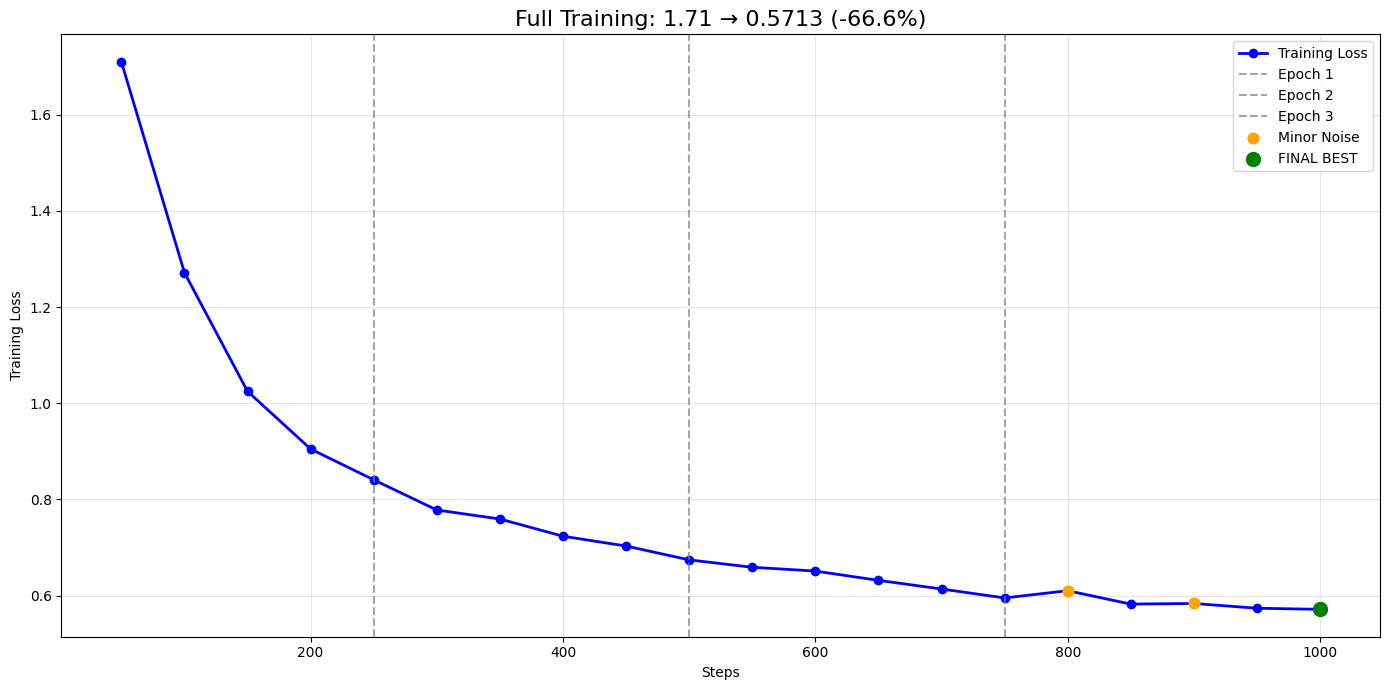

In [ ]:
# plotting losses
import matplotlib.pyplot as plt

steps = [50,100,150,200,250,300,350,400,450,500,550,600,650,700,750,800,850,900,950,1000]
losses = [1.7103,1.2716,1.0247,0.9048,0.8407,0.7779,0.7592,0.7234,0.7030,
          0.6742,0.6588,0.6509,0.6316,0.6136,0.5950,0.6101,0.5822,0.5835,0.5736,0.5713]

plt.figure(figsize=(14, 7))
plt.plot(steps, losses, 'o-', label='Training Loss', color='blue', linewidth=2)
plt.axvline(250, color='gray', linestyle='--', alpha=0.7, label='Epoch 1')
plt.axvline(500, color='gray', linestyle='--', alpha=0.7, label='Epoch 2')
plt.axvline(750, color='gray', linestyle='--', alpha=0.7, label='Epoch 3')
plt.scatter([800,900], [0.6101,0.5835], color='orange', s=60, label='Minor Noise', zorder=5)
plt.scatter(1000, 0.5713, color='green', s=100, label='FINAL BEST', zorder=5)
plt.title('Full Training: 1.71 → 0.5713 (-66.6%)', fontsize=16)
plt.xlabel('Steps')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [ ]:
trainer.evaluate()

Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
Transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English. This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`. See https://github.com/huggingface/transformers/pull/28687 for more details.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


{'eval_loss': 0.5903539061546326,
 'eval_wer': 82.24852071005917,
 'eval_runtime': 661.2628,
 'eval_samples_per_second': 0.762,
 'eval_steps_per_second': 0.095,
 'epoch': 3.5220458553791887}

In [ ]:
import evaluate
import torch

wer_metric = evaluate.load("wer")

def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

In [ ]:
import torch
import numpy as np
from transformers import WhisperProcessor, WhisperForConditionalGeneration
from datasets import load_from_disk
import evaluate

# Load the dataset and model
nepali_train = load_from_disk("/content/drive/MyDrive/nepali_whisper_processed")
processor = WhisperProcessor.from_pretrained("openai/whisper-small", language="ne", task="transcribe")

# Load your trained model (use the latest checkpoint)
model_path = f"/content/drive/MyDrive/whisper-small-nep-parliament/checkpoint-1000"  # or specific checkpoint
model = WhisperForConditionalGeneration.from_pretrained(model_path)
model.eval()

# Load WER metric
wer_metric = evaluate.load("wer")

def predict_and_compare(model, processor, dataset, num_samples=10):
    """Compare model predictions with ground truth"""

    results = []
    wer_scores = []

    # Get random samples from test set
    test_dataset = dataset["test"]
    indices = np.random.choice(len(test_dataset), min(num_samples, len(test_dataset)), replace=False)

    print(" Comparing Predictions vs Ground Truth:\n")
    print("=" * 100)

    for i, idx in enumerate(indices):
        # Convert numpy index to standard integer
        sample = test_dataset[int(idx)]

        # Get input features
        input_features = torch.tensor(sample["input_features"]).unsqueeze(0)

        # Generate prediction
        with torch.no_grad():
            predicted_ids = model.generate(input_features, max_length=225)

        # Decode predictions and labels
        prediction = processor.tokenizer.decode(predicted_ids[0], skip_special_tokens=True)

        # Get ground truth (remove -100 padding)
        label_ids = sample["labels"]
        label_ids = [token_id for token_id in label_ids if token_id != -100]
        ground_truth = processor.tokenizer.decode(label_ids, skip_special_tokens=True)

        # Calculate WER for this sample
        wer = wer_metric.compute(predictions=[prediction], references=[ground_truth])
        wer_scores.append(wer)

        results.append({
            'prediction': prediction,
            'ground_truth': ground_truth,
            'wer': wer
        })

        # Print comparison
        print(f"Sample {i+1}:")
        print(f"Ground Truth: {ground_truth}")
        print(f"Prediction:   {prediction}")
        print(f"WER: {wer:.2%}")
        print("-" * 80)

    # Overall statistics
    avg_wer = np.mean(wer_scores)
    print(f"\nOverall Average WER: {avg_wer:.2%}")
    print(f"WER Range: {np.min(wer_scores):.2%} - {np.max(wer_scores):.2%}")

    return results, wer_scores

# Run prediction comparison
results, wer_scores = predict_and_compare(model, processor, nepali_train, num_samples=10)

 Comparing Predictions vs Ground Truth:

Sample 1:
Ground Truth: प्रोटोस्टोम जनावरहरूको समूह
Prediction:    प्रुटेस्टौं जनाँँरहरुको समह
WER: 100.00%
--------------------------------------------------------------------------------
Sample 2:
Ground Truth: इटालियन मूर्तिकार चित्रकार आर्किटेक्ट र कवि
Prediction:   इतालीयन मुर्तिकार चित्रकार आर्किटेक र गबी
WER: 66.67%
--------------------------------------------------------------------------------
Sample 3:
Ground Truth: पुष्प नेपाली नेपालका वरिष्ठ गायक गीतकार उनी सङ्गीतकार हुन्
Prediction:    पुस्पनेपाली नेपालका बरिस्ट गाई गित्कार उनि संगितकार हुन्
WER: 77.78%
--------------------------------------------------------------------------------
Sample 4:
Ground Truth: सुर्खेत विमानस्थल नेपालको राजधानी काठमाडौँबाट सात सय किमी टाढा सुर्खेत उपत्यकाको वीरेन्द्रनगर सहरसँगै रहेको छ
Prediction:    सुर्खेत बिमान स्थल नेपालको राज्दानी काठ्माडौँबाट चाध्चै किलोमिटर टाडा सुर्खेत उप्त्यकाको बिरेन्द्र नगर सहर सङ्गै रहेको छ
WER: 86.67%
-----------------------

Original model before finetuning

In [ ]:
import evaluate
import torch
import numpy as np # Import numpy

wer_metric = evaluate.load("wer")

def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

def compare_with_base_model(num_samples=5):
    """Compare your fine-tuned model with the base Whisper model"""

    # Load base model
    base_model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")
    base_processor = WhisperProcessor.from_pretrained("openai/whisper-small")
    base_model.eval()

    test_dataset = nepali_train["test"]
    indices = np.random.choice(len(test_dataset), min(num_samples, len(test_dataset)), replace=False)

    print(" Comparison: Fine-tuned vs Base Model")
    print("=" * 100)

    for i, idx in enumerate(indices):
        # Convert numpy index to standard integer
        sample = test_dataset[int(idx)] # Corrected here
        input_features = torch.tensor(sample["input_features"]).unsqueeze(0)

        # Your fine-tuned model prediction
        with torch.no_grad():
            fine_tuned_pred = model.generate(input_features, max_length=225)
        ft_prediction = processor.tokenizer.decode(fine_tuned_pred[0], skip_special_tokens=True)

        # Base model prediction
        with torch.no_grad():
            base_pred = base_model.generate(input_features, max_length=225)
        base_prediction = base_processor.tokenizer.decode(base_pred[0], skip_special_tokens=True)

        # Ground truth
        label_ids = sample["labels"]
        label_ids = [token_id for token_id in label_ids if token_id != -100]
        ground_truth = processor.tokenizer.decode(label_ids, skip_special_tokens=True)

        # Calculate WER
        ft_wer = wer_metric.compute(predictions=[ft_prediction], references=[ground_truth])
        base_wer = wer_metric.compute(predictions=[base_prediction], references=[ground_truth])

        print(f"Sample {i+1}:")
        print(f"Ground Truth: {ground_truth}")
        print(f"Fine-tuned:   {ft_prediction} (WER: {ft_wer:.2%})")
        print(f"Base Model:   {base_prediction} (WER: {base_wer:.2%})")
        # Avoid division by zero if base_wer is 0
        improvement = ((base_wer - ft_wer) / base_wer * 100) if base_wer != 0 else float('inf')
        print(f"Improvement:  {improvement:+.1f}%")
        print("-" * 80)

# Uncomment to run comparison
compare_with_base_model(num_samples=3)

 Comparison: Fine-tuned vs Base Model
Sample 1:
Ground Truth: सदस्यहरू, अब म सम्माननीय प्रधानमन्त्री पुष्पकमल दाहाल ""प्रचण्ड"" को तर्फबाट माननीय कृषि तथा पशुपन्छी बिकास मन्त्री डाक्टर बेदुराम भुसाललाई छलफलमा उठेका प्रश्नहरूको जवाफ दिन समय उपलब्ध गराउँछु । सम्माननीय अध्यक्ष महोदय, भ्रष्टाचार निवारण
Fine-tuned:   आबमा सम्माननीय प्रदान मत्री पुष्कमल डाल प्र्च्टन्डको तर्फौँवाट अमानीय किर्षी त था पस्वूपन्ची विकास मन्त्री डाक्टर वेदुराम बुषालाई छाल्फलमा अवठेका प्रष्नाहरूको जवाव दिन समय अपलब्द गराउँछ्छ� (WER: 87.88%)
Base Model:   , (WER: 100.00%)
Improvement:  +12.1%
--------------------------------------------------------------------------------
Sample 2:
Ground Truth: आफ्नो भविष्य खोज्ने वातावरण नबनाउनजेल कृषि उत्पादनमा बृद्धि र आत्मनिर्भरता सम्भव देखिँदैन । सहुलियत र अनुदान बिचौलियाले खाने समयमा मल नपाउने कतिपय क्षेत्रमा चे खेती गर्नपर्ने अझै पनि आकाशे खेती गर्नुपर्ने र हाम्रो खेती परम्परावादी र निर्वाहमुखी नै हुने कुराले पनि
Fine-tuned:    आफ्नो बविष्य खोष्ने बातावर नबनाउन्जल किर्षी उत्

In [ ]:
import torch
from transformers import WhisperProcessor, WhisperForConditionalGeneration
import soundfile as sf
import librosa # Import librosa for resampling

# -----------------------------
# Load fine-tuned model and processor
# -----------------------------
model_path = "/content/drive/MyDrive/whisper-small-nep-parliament/checkpoint-1000"  # path to saved model

# Load processor from the original model with language/task settings
processor = WhisperProcessor.from_pretrained("openai/whisper-small", language="ne", task="transcribe")

# Load model from the fine-tuned checkpoint
model = WhisperForConditionalGeneration.from_pretrained(model_path)
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# -----------------------------
#  Load audio
# -----------------------------
audio_file = "/content/drive/MyDrive/audio_1_denoised.wav"  # replace with your audio path
speech_array, original_sampling_rate = sf.read(audio_file) # Renamed sampling_rate to original_sampling_rate

# -----------------------------
# Preprocess audio
# -----------------------------
# Resample audio to 16kHz if necessary
if original_sampling_rate != 16000:
    speech_array = librosa.resample(speech_array, orig_sr=original_sampling_rate, target_sr=16000)
    sampling_rate = 16000 # Update sampling_rate to 16000
else:
    sampling_rate = original_sampling_rate

# Ensure input_features is a 3D tensor: (batch_size, num_mel_bins, sequence_length)
input_features = processor.feature_extractor(
    speech_array,
    sampling_rate=sampling_rate,
    return_tensors="pt" # Return PyTorch tensors, which will include a batch dimension
).input_features.to(device)

# -----------------------------
# Generate transcription
# -----------------------------
# Use generate() for auto-regressive decoding
predicted_ids = model.generate(input_features, max_new_tokens=225)
transcription = processor.tokenizer.batch_decode(predicted_ids, skip_special_tokens=True)[0]

print("Transcription:", transcription)

The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Transcription:  यहाँ राख्ना छाहे र रहार्खौविशै यतिवेला साम्दी सम्जौता त्यो पनाउ खम्ण गरेर फेरी यु देशलाई दुन्द्यतिर भइजारेक्षुँगा अध्यक्तिहरू खाड्नाकरामहरू भही रहेका छन्‌ । त्यस्वैको कार्ण मके भन्न चाहन्छु भने जन


## Further finetuning to reduce wer using slr54 data

In [ ]:
import torch
import torchaudio
from transformers import (
    WhisperProcessor,
    WhisperForConditionalGeneration,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    EarlyStoppingCallback
)
from datasets import Dataset, Audio, load_dataset
import evaluate
import numpy as np
from peft import LoraConfig, get_peft_model, TaskType
import os
from typing import Dict, List, Union
import json

In [ ]:
def load_fleurs_nepali_dataset():
    """Load Google FLEURS Nepali dataset"""
    from datasets import load_dataset

    # Load FLEURS dataset for Nepali
    dataset = load_dataset("google/fleurs", "ne_np", split="train+validation+test")

    return dataset

# Load dataset
print("Loading FLEURS Nepali dataset...")
dataset = load_fleurs_nepali_dataset()

# Split dataset
train_test_split = dataset.train_test_split(test_size=0.1, seed=42)
train_dataset = train_test_split["train"]
eval_dataset = train_test_split["test"]

print(f"Training samples: {len(train_dataset)}")
print(f"Evaluation samples: {len(eval_dataset)}")

Loading FLEURS Nepali dataset...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


The repository for google/fleurs contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/google/fleurs.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Training samples: 3926
Evaluation samples: 437


In [ ]:
# Cast the audio column to Audio feature type for compatibility
nepali_train = train_dataset.cast_column("audio", Audio(sampling_rate=16_000))

print(f"Loaded {len(nepali_train)} training samples.")
print(nepali_train)
print(nepali_train[0])

Loaded 3926 training samples.
Dataset({
    features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'],
    num_rows: 3926
})
{'id': 1023, 'num_samples': 194880, 'path': '/root/.cache/huggingface/datasets/downloads/extracted/c436bf160141018f65f665701e4d2745395d5bc44296bb8af0c494b7c7be840f/4248760263821455814.wav', 'audio': {'path': 'train/4248760263821455814.wav', 'array': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
        1.98483467e-05, -3.81469727e-05, -2.57492065e-05]), 'sampling_rate': 16000}, 'transcription': 'कीराहरूले खाना बिगार्न जलन पैदा गर्न वा खराब अवस्थामा एलर्जीको प्रतिक्रियाहरू निम्त्याउन विष फैलाउन वा सङ्क्रमण सार्न सक्छन्', 'raw_transcription': 'कीराहरूले खाना बिगार्न, जलन पैदा गर्न वा खराब अवस्थामा एलर्जीको प्रतिक्रियाहरू निम्त्याउन, विष फैलाउन वा सङ्क्रमण सार्न सक्छन्।', 'gender': 1, 'lang_id': 66, 'language': 'Nepali', 'lang_group_id': 4}


In [ ]:
# Cast the audio column to Audio feature type for compatibility
nepali_eval = eval_dataset.cast_column("audio", Audio(sampling_rate=16_000))

print(f"Loaded {len(eval_dataset)} training samples.")
print(eval_dataset)
print(eval_dataset[0])

Loaded 437 training samples.
Dataset({
    features: ['id', 'num_samples', 'path', 'audio', 'transcription', 'raw_transcription', 'gender', 'lang_id', 'language', 'lang_group_id'],
    num_rows: 437
})
{'id': 1560, 'num_samples': 119040, 'path': '/root/.cache/huggingface/datasets/downloads/extracted/4534e50df892997d26ef10833168cd462548e1cf90c23e5b966e1a736743378a/274775832030013125.wav', 'audio': {'path': 'dev/274775832030013125.wav', 'array': array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
       -1.39117241e-04,  4.72068787e-05,  1.50561333e-04]), 'sampling_rate': 16000}, 'transcription': 'तपाईं बेगबाट बाहिर निस्कनेबित्तिकै पौडी खेल्नु सामान्यभन्दा धेरै गाह्रो हुँदैन', 'raw_transcription': 'तपाईं बेगबाट बाहिर निस्कनेबित्तिकै पौडी खेल्नु सामान्यभन्दा धेरै गाह्रो हुँदैन।', 'gender': 0, 'lang_id': 66, 'language': 'Nepali', 'lang_group_id': 4}


In [ ]:
from transformers import WhisperProcessor
from datasets import DatasetDict

processor = WhisperProcessor.from_pretrained("openai/whisper-small", language="ne", task="transcribe")

# CELL — Correct preprocessing function (THIS IS THE ONE THAT WORKS)
def prepare(example):
    audio = example["audio"]["array"]
    example["input_features"] = processor.feature_extractor(
        audio, sampling_rate=16000
    ).input_features[0]                                      # ← (80, 3000) correct shape

    example["labels"] = processor.tokenizer(
        example["transcription"],                            # ← use "transcription", not raw
        truncation=True,
        max_length=448
    ).input_ids
    return example

# CELL — Preprocess both splits (fast + clean)
print("Preprocessing train...")
train = nepali_train.map(prepare, remove_columns=nepali_train.column_names, num_proc=1)

print("Preprocessing eval...")
eval = nepali_eval.map(prepare, remove_columns=nepali_eval.column_names, num_proc=4)

# Combine into DatasetDict
final_dataset = DatasetDict({"train": train, "validation": eval})

# Save forever
final_path = "/content/drive/MyDrive/nepali_whisper_final_processed"
final_dataset.save_to_disk(final_path)

print(f"DONE! Preprocessed dataset saved → {final_path}")
print(f"Train: {len(train)} | Eval: {len(eval)}")

In [3]:
from datasets import load_from_disk
ds = load_from_disk("/content/drive/MyDrive/nepali_whisper_final_processed")
ds_train = ds["train"]
ds_eval = ds["validation"]

In [7]:
# Check what's actually in your checkpoint
import os
checkpoint_path = "/content/drive/MyDrive/whisper-small-nep-parliament/checkpoint-1000"

print("=== Checkpoint Analysis ===")
print("Files in checkpoint:")
for file in os.listdir(checkpoint_path):
    file_path = os.path.join(checkpoint_path, file)
    size = os.path.getsize(file_path) / 1024 / 1024
    print(f"  {file}: {size:.2f} MB")

# Check if this is the right checkpoint
if "trainer_state.json" in os.listdir(checkpoint_path):
    import json
    with open(os.path.join(checkpoint_path, "trainer_state.json"), 'r') as f:
        state = json.load(f)
        print(f"Checkpoint step: {state.get('step', 'unknown')}")
        print(f"Checkpoint loss: {state.get('log_history', [{}])[-1].get('loss', 'unknown')}")

=== Checkpoint Analysis ===
Files in checkpoint:
  training_args.bin: 0.01 MB
  preprocessor_config.json: 0.00 MB
  rng_state.pth: 0.01 MB
  scaler.pt: 0.00 MB
  trainer_state.json: 0.00 MB
  scheduler.pt: 0.00 MB
  README.md: 0.00 MB
  optimizer.pt: 9.08 MB
  adapter_config.json: 0.00 MB
  adapter_model.safetensors: 6.77 MB
Checkpoint step: unknown
Checkpoint loss: 0.5713


In [8]:
import torch
from dataclasses import dataclass
from typing import Any, Dict, List, Union

from transformers import (
    WhisperProcessor,
    WhisperForConditionalGeneration,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer
)
from peft import prepare_model_for_kbit_training, LoraConfig, get_peft_model, PeftModel

import evaluate # Import evaluate for wer_metric
wer_metric = evaluate.load("wer") # Load the WER metric here

# Define compute_metrics function
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = processor.tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = processor.tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = processor.tokenizer.batch_decode(label_ids, skip_special_tokens=True)

    wer = 100 * wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

# -----------------------------
# CORRECTED Data collator for Whisper
# -----------------------------
@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # input_features already processed, just stack them
        input_features = [torch.tensor(f["input_features"]) for f in features]

        # Pad input features to same length
        input_features = torch.nn.utils.rnn.pad_sequence(
            input_features, batch_first=True, padding_value=0.0
        )

        # Handle labels
        label_features = [{"input_ids": f["labels"]} for f in features]
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch = {
            "input_features": input_features,
            "labels": labels,
        }
        return batch

# -----------------------------
# Custom Trainer to handle 'num_items_in_batch'
# -----------------------------
class CustomSeq2SeqTrainer(Seq2SeqTrainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs): # Added **kwargs to capture extra arguments
        # Pop num_items_in_batch from kwargs if it's passed as a keyword argument
        kwargs.pop("num_items_in_batch", None)

        # Also, ensure 'num_items_in_batch' is not in the 'inputs' dictionary itself,
        # as the model's forward method does not expect it.
        inputs.pop("num_items_in_batch", None)

        # Now call the super method, passing only the arguments it expects
        return super().compute_loss(model, inputs, return_outputs=return_outputs)

# -----------------------------
# Training parameters
# -----------------------------
model_id = "small"
task = "transcribe"
language = "ne"

# LoRA parameters
r = 16
lora_alpha = 32
lora_dropout = 0.1

# Training parameters
learning_rate = 1e-4
train_batch_size = 8  # Reduced to avoid memory issues
gradient_accumulation_steps = 2
fp16 = True
warmup_steps = 100
max_steps = 1500
save_steps = 300
logging_steps = 50

experiment_name = f"whisper-{model_id}-nep-final"

# -----------------------------
# Load processor and model
# -----------------------------
processor = WhisperProcessor.from_pretrained(
    f"openai/whisper-{model_id}",
    language=language,
    task=task
)

# Load model
model = WhisperForConditionalGeneration.from_pretrained(
    f"openai/whisper-{model_id}",
    device_map="auto"
)

# Configure model
model.config.forced_decoder_ids = None
model.config.suppress_tokens = []
model.config.use_cache = False
model.gradient_checkpointing_enable()

# -----------------------------
# Apply LoRA
# -----------------------------
model.enable_input_require_grads()
checkpoint_path = "/content/drive/MyDrive/whisper-small-nep-parliament/checkpoint-1000"
peft_config = LoraConfig(
    r=r,
    lora_alpha=lora_alpha,
    target_modules=["q_proj", "v_proj"],
    lora_dropout=lora_dropout,
    bias="none",
)

model = PeftModel.from_pretrained(model, checkpoint_path)
model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

# -----------------------------
# Data collator
# -----------------------------
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

# -----------------------------
# Training arguments
# -----------------------------
training_args = Seq2SeqTrainingArguments(
    output_dir=f"/content/drive/MyDrive/{experiment_name}",
    per_device_train_batch_size=train_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    learning_rate=learning_rate,
    warmup_steps=warmup_steps,
    max_steps=max_steps,
    save_steps = save_steps,
    logging_steps=logging_steps,
    eval_steps=300,
    save_total_limit=3,
    predict_with_generate=True,
    generation_max_length=225,
    report_to=["tensorboard"],
    remove_unused_columns=False,
    fp16=fp16,
)

# -----------------------------
# Trainer
# -----------------------------
trainer = CustomSeq2SeqTrainer( # Use the custom trainer
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_eval,
    data_collator=data_collator,
    tokenizer=processor.feature_extractor,
    compute_metrics=compute_metrics,
)

# Start training
trainer.train()

/usr/local/lib/python3.12/dist-packages/peft/mapping_func.py:73: UserWarning: You are trying to modify a model with PEFT for a second time. If you want to reload the model with a different config, make sure to call `.unload()` before.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/peft/tuners/tuners_utils.py:196: UserWarning: Already found a `peft_config` attribute in the model. This will lead to having multiple adapters in the model. Make sure to know what you are doing!
  warnings.warn(
/tmp/ipython-input-2783564199.py:165: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `CustomSeq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = CustomSeq2SeqTrainer( # Use the custom trainer
The model is already on multiple devices. Skipping the move to device specified in `args`.


trainable params: 1,769,472 || all params: 243,504,384 || trainable%: 0.7267


You're using a WhisperTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


Step,Training Loss
50,3.295000
100,2.330000
150,1.837200
200,1.651700
250,1.470600
300,1.433000
350,1.403800
400,1.337100
450,1.297300
500,1.227000


/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torch/utils/checkpoint.py:85: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


TrainOutput(global_step=1500, training_loss=1.1838402252197266, metrics={'train_runtime': 5374.1876, 'train_samples_per_second': 4.466, 'train_steps_per_second': 0.279, 'total_flos': 6.9697345536e+18, 'train_loss': 1.1838402252197266, 'epoch': 6.097759674134419})

In [16]:
# Save the final model
trainer.save_model("/content/drive/MyDrive/whisper-np-final")
model.save_pretrained("/contetn/drive/MyDrive/whisper-np-final")

print("Final model saved!")

Final model saved!


In [11]:
# Get final WER/CER metrics
trainer.args.predict_with_generate = True
final_metrics = trainer.evaluate(ds_eval)

print("Final Evaluation Metrics:")
print(f"Loss: {final_metrics['eval_loss']:.4f}")
print(f"WER: {final_metrics.get('eval_wer', 'N/A')}")

Using custom `forced_decoder_ids` from the (generation) config. This is deprecated in favor of the `task` and `language` flags/config options.
Transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English. This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`. See https://github.com/huggingface/transformers/pull/28687 for more details.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


Final Evaluation Metrics:
Loss: 0.4300
WER: 66.26189283925889


In [19]:
import random
import torch

# Ensure the model is on the correct device if not already
if torch.cuda.is_available():
    model.to("cuda")

# Test a few samples
for i in range(3):
    sample = ds_eval[i]

    # Use pre-processed input_features directly
    input_features = torch.tensor(sample["input_features"]).unsqueeze(0).to(model.device)

    # Generate prediction
    with torch.no_grad():
        generated_ids = model.generate(input_features, max_new_tokens=225)

    prediction = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Decode labels for ground truth
    # Remove -100 (padding) token IDs before decoding
    label_ids = [token_id for token_id in sample["labels"] if token_id != -100]
    truth = processor.tokenizer.decode(label_ids, skip_special_tokens=True)

    print(f"Sample {i}:")
    print(f"  Truth: {truth}")
    print(f"  Prediction: {prediction}")
    print()

Sample 0:
  Truth: तपाईं बेगबाट बाहिर निस्कनेबित्तिकै पौडी खेल्नु सामान्यभन्दा धेरै गाह्रो हुँदैन
  Prediction: तपाईं बेगबाट बाँट बाइर निस्किन वितिकै पोडी खेल्नु समान्नीयभन्दा धेरै गारो हुँदैन्

Sample 1:
  Truth: सन् 1966 देखि सुन्दरबन वन्यजन्तु आरक्षण केन्द्र भएको छ र यस क्षेत्रमा अहिले 400 वटा शाही बंगाल बाघ र लगभग 30,000 हरिणहरू रहेको अनुमान गरिएको छ
  Prediction: शन्णौनेश्टै शेषार्देकी सुन्दरबन्ड भनियजन्तु आराक्षन केन्द्र भएको छ र यस क्षेत्रमा अइले चार्षैवटा साहीभगाल बाग र लगबक 30 अजार हरीनहरू रहेको अनुमान गरिएको छ

Sample 2:
  Truth: इबे वा क्रेगलिस्ट जस्ता लिलामी वेबसाइटबाट बिक्री गरिने धेरैजसो टिकटहरू आंशिक रूपमा प्रयोग गरिएका धेरै दिनका पार्क-होपर टिकट हुन्छन्
  Prediction: एबे र क्रेग्लिस जस्तालीलामी वेब्साइट बाट बिक्री गरिने देरै जस्तो टिकेटहरू अधिकाङ्ख्स रूपमा प्रयोग गरिएका देरै दिनका पार्क एपर टिकेट हुन्छन्



In [3]:
from huggingface_hub import notebook_login

# This will prompt for your HF token
notebook_login()

In [ ]:
from transformers import WhisperForConditionalGeneration, WhisperProcessor

# Load your final model (if not already loaded)
checkpoint_path = "/content/drive/MyDrive/whisper-np-final"
model = WhisperForConditionalGeneration.from_pretrained("openai/whisper-small")
processor = WhisperProcessor.from_pretrained("openai/whisper-small", language="ne", task="transcribe")

# Push to Hub
repo_name = "whisper-small-nep"  # Choose your repo name

# Push the PEFT adapter
model.push_to_hub(repo_name)

# Push the processor
processor.push_to_hub(repo_name)

print(f"✅ Model pushed to: https://huggingface.co/your_username/{repo_name}")